In [275]:
from gurobipy import Model, GRB, quicksum

# Define the parameters based on the given and assumed data
#month = ['May','June','July','Aug','Sep','Oct','Nov','Dec','Jan','Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec','Jan','Feb','March','April']  # Number of periods (in months)
M=36 # Number of periods (in months)
L = 4  # Number of plots
C = ['Wheat', 'Canola', 'Oat','Lentils', 'Hairy Vetch', 'Winter Rye', 'Winter Wheat']  # Set of main crops (cash crops)
F = {'Poaceae': ['Wheat','Winter Rye','Oat', 'Winter Wheat'],
     'Brassicaceae': ['Canola'],
     'Papilionaceae': ['Lentils'],
     'Vicia Villosa': ['Hairy Vetch']
     } # Botanical families and their crops

acre_per_plot = 446*0.90 # we assume that 10% of the land is not used for growing crops
total_acre_per_plot = 446

duration = {'Wheat': 5, 'Canola': 5, 'Oat': 5, 'Lentils': 5, 'Hairy Vetch': 7, 'Winter Rye': 7, 'Winter Wheat': 7}  # Duration of each crop
bushels_per_acre = {'Wheat': 44.1, 'Canola':36.1, 'Oat': 53.8, 'Lentils (lb/a)': 1344.8, 'Hairy Vetch': 6, 'Winter Rye': 34.3, 'Winter Wheat': 41.9} # orginal yield numbers
weight_per_bushel = {'Wheat': 60, 'Canola': 50, 'Oat': 34, 'Lentils': 1, 'Hairy Vetch': 60, 'Winter Rye': 56, 'Winter Wheat': 60}
Yield_max = {'Wheat': bushels_per_acre['Wheat']*weight_per_bushel['Wheat'], 'Canola': bushels_per_acre['Canola']*weight_per_bushel['Canola'], 
             'Oat': bushels_per_acre['Oat']*weight_per_bushel['Oat'], 'Lentils': bushels_per_acre['Lentils (lb/a)']*weight_per_bushel['Lentils'], 
             'Hairy Vetch': bushels_per_acre['Hairy Vetch']*weight_per_bushel['Hairy Vetch'], 'Winter Rye': bushels_per_acre['Winter Rye']*weight_per_bushel['Winter Rye'], 'Winter Wheat': bushels_per_acre['Winter Wheat']*weight_per_bushel['Winter Wheat']}  #pound per acre
min_yield_percentage = 0.75
Yield_min = {'Wheat': Yield_max['Wheat']*min_yield_percentage, 'Canola': Yield_max['Canola']*min_yield_percentage,
                'Oat': Yield_max['Oat']*min_yield_percentage, 'Lentils': Yield_max['Lentils']*min_yield_percentage,
                'Hairy Vetch': Yield_max['Hairy Vetch']*min_yield_percentage, 'Winter Rye': Yield_max['Winter Rye']*min_yield_percentage, 'Winter Wheat': Yield_max['Winter Wheat']*min_yield_percentage}  #pound per acre
Seed = {'Wheat': 24.96, 'Canola': 79.75, 'Oat': 27.20, 'Lentils': 60.06, 'Hairy Vetch':126.99 , 'Winter Rye': 47.25, 'Winter Wheat': 31.35}  # Cost of seeds per acre
Price_per_bushel = {'Wheat': 10.15, 'Canola': 17.61, 'Oat': 5.19, 'Lentils ($/lb)': 0.49, 'Hairy Vetch ($/lb)': 2, 'Winter Rye': 7.92, 'Winter Wheat': 9.91}  # Price per bushel
Revenue = {'Wheat': Price_per_bushel['Wheat']/weight_per_bushel['Wheat'], 'Canola': Price_per_bushel['Canola']/weight_per_bushel['Canola'],
                'Oat': Price_per_bushel['Oat']/weight_per_bushel['Oat'], 'Lentils': Price_per_bushel['Lentils ($/lb)']/weight_per_bushel['Lentils'],
                    'Hairy Vetch': Price_per_bushel['Hairy Vetch ($/lb)'], 'Winter Rye': Price_per_bushel['Winter Rye']/weight_per_bushel['Winter Rye'], 'Winter Wheat': Price_per_bushel['Winter Wheat']/weight_per_bushel['Winter Wheat']}  # Revenue per acre
nutrients = ['Nitrogen', 'Phosphorus', 'Potassium']  # Set of nutrients
# Nutrient consumption per crop
nutrient_consumption = {
    'Wheat': {'Nitrogen': 68, 'Phosphorus': 48, 'Potassium': 65},
    'Canola': {'Nitrogen': 76, 'Phosphorus': 41, 'Potassium': 73},
    'Oat': {'Nitrogen': 37, 'Phosphorus': 15, 'Potassium': 131},
    'Lentils': {'Nitrogen': 0, 'Phosphorus': 15, 'Potassium': 69},
    'Hairy Vetch': {'Nitrogen': 0, 'Phosphorus': 33, 'Potassium': 47}, 
    'Winter Rye': {'Nitrogen': 40, 'Phosphorus': 17, 'Potassium': 12},
    'Winter Wheat': {'Nitrogen': 48, 'Phosphorus': 23, 'Potassium': 65}
}
# Residual percentages for each crop
residual_percentage = {'Wheat': 0.05, 'Canola': 0.05, 'Oat': 0.05, 'Winter Rye': 0.05,  'Winter Wheat': 0.05}
# Nitrogen production of each crop   
nitrogen_production = {'Wheat': nutrient_consumption['Wheat']['Nitrogen']*residual_percentage['Wheat'], 'Canola': nutrient_consumption['Canola']['Nitrogen']*residual_percentage['Canola'], 
                       'Oat': nutrient_consumption['Oat']['Nitrogen']*residual_percentage['Oat'], 'Lentils': 85.64, 'Hairy Vetch': 100, 
                       'Winter Rye': nutrient_consumption['Winter Rye']['Nitrogen']*residual_percentage['Winter Rye'], 'Winter Wheat': nutrient_consumption['Winter Wheat']['Nitrogen']*residual_percentage['Winter Wheat']}
#Fertilizer cost per unit of nutrient
Fertilizer_cost ={'Nitrogen': 0.50, 'Phosphorus': 0.55, 'Potassium': 0.66}

# Constraint: Specific months for growing certain crops
allowed_months = {
    'Wheat': [0,12,24],
    'Canola': [0,12,24],
    'Oat': [0,12,24],
    'Lentils': [0,12,24],
    'Hairy Vetch': [5,17,29], #[5, 6, 17, 18]
    'Winter Rye': [5,17,29],
    'Winter Wheat': [5,17,29]
}

A = {0: [1, 2], 1: [0, 3], 2: [0, 3], 3: [1, 2]}  # Adjacency list for plots
B = 4500000  # Total budget (assumed)

# Initialize the model
m = Model('AgricultureOptimization')

MAKE THE CODE FOR 3 SEASONS AND UNCERTAINTY OF YIELD

In [276]:
# Decision variables
x = m.addVars(C, M,L, vtype=GRB.BINARY, name="x")  # Planting decision
# Decision variables for nutrient amendment
Z = m.addVars(nutrients, M, L, vtype=GRB.CONTINUOUS, name="Z")
# Decision variables for nutrient stored
S = m.addVars(nutrients, M, L, vtype=GRB.CONTINUOUS, name="S")



In [277]:
# basic
# S for month 0 is 15 for nitrogen and 100 for phosphorus and 28 for potassium
m.addConstrs(S['Nitrogen', 0, l] == 15*acre_per_plot for l in range(L))
m.addConstrs(S['Phosphorus', 0, l] == 100*acre_per_plot for l in range(L))
m.addConstrs(S['Potassium', 0, l] == 28*acre_per_plot for l in range(L))


{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>}

In [278]:
for j in range(M):  # For each month
    for k in range(L):  # For each plot
        for i in C:  # For each crop
            # If crop i is planted at month j on plot k, no other crop can be planted on plot k for the duration of crop i
            m.addConstr(quicksum(x[i, j, k] * quicksum(x[c, t, k] for c in C for t in range(j, min(j + duration[i], M))) for i in C) <= 1, f"exclusive_duration_{j}_{k}")


#Constraint 1a: at most one crop per plot per period (NOT NEEDED)
#for j in range(M):
    #for k in range(L):
        #m.addConstr(quicksum(x[i, j, k] for i in C) <= 1, f"crop_continuity_{j}_{k}")


In [279]:
# Define the plant variable
# Define variables
plant = m.addVars(F.keys(), M, L, vtype=GRB.BINARY, name="plant")

# Large constant M for the big-M method
big_M = 1e6

for month in range(M):
    for plot in range(L):
        # Binary variable to indicate if any crop is planted on plot in month
        is_planted = m.addVar(vtype=GRB.BINARY, name=f"is_planted_{month}_{plot}")

        # Update is_planted based on whether any crop is planted
        m.addConstr(is_planted == quicksum(x[crop, month, plot] for crop in C))

        for family in F.keys():
            if month == 0:
                # Initialize plant for the first month
                m.addConstr(plant[family, month, plot] == quicksum(x[crop, month, plot] for crop in C if crop in F[family]))
            else:
                # Plant family value for previous month
                prev_plant = plant[family, month - 1, plot]

                # Update plant based on is_planted
                m.addConstr(plant[family, month, plot] <= quicksum(x[crop, month, plot] for crop in C if crop in F[family]) + big_M * (1 - is_planted))
                m.addConstr(plant[family, month, plot] >= quicksum(x[crop, month, plot] for crop in C if crop in F[family]) - big_M * (1 - is_planted))

                # Carry forward plant if no crop is planted
                m.addConstr(plant[family, month, plot] <= prev_plant + big_M * is_planted)
                m.addConstr(plant[family, month, plot] >= prev_plant - big_M * is_planted)






In [280]:
# basic
# crop cannot be planted in a month if the duration ends after the last month of the timeframe
for i in C:
    for j in range(M-duration[i]+1,M):
        for k in range(L):
            m.addConstr(x[i,j,k]==0)

In [281]:
for month in range(1, M):  # Start from the second month (assuming month indexing starts from 0)
    for plot in range(L):
        for crop in C:
            family_of_crop = next(f for f in F.keys() if crop in F[f])  # Determine the family of the current crop
            # Prevent planting crop if its family was the most recently planted family
            m.addConstr(
                (x[crop, month, plot] == 1) >> (plant[family_of_crop, month - 1, plot] == 0),
                f"prevent_same_family_succession_{crop}_{month}_{plot}"
            )

In [282]:
# Constraint to prevent adjacent plots from growing crops of the same family
for month in range(M):
    for plot in range(L):
        adjacent_plots = A[plot]  # Get the list of adjacent plots
        for crop in C:
            family_of_crop = next(f for f in F.keys() if crop in F[f])  # Determine the family of the current crop
            for adjacent_plot in adjacent_plots:
                for adjacent_crop in C:
                    if adjacent_crop in F[family_of_crop]:
                        # Check if the adjacent plot is growing a crop from the same family
                        # and ensure the current crop's duration overlaps with the adjacent crop's duration
                        for t in range(max(0, month - duration[adjacent_crop] + 1), min(month + duration[crop], M)):
                            m.addConstr(
                                x[crop, month, plot] + x[adjacent_crop, t, adjacent_plot] <= 1,
                                f"prevent_adjacent_family_{crop}_{month}_{plot}_{adjacent_crop}_{t}_{adjacent_plot}"
                            )

In [283]:
# basic
#Constraint 4: Crops can grow only in allowed months
for c in C:  # For each crop
    for j in range(M):  # For each month
        for k in range(L):  # For each plot
            if j not in allowed_months[c]:
                # If the month is not allowed for the crop, ensure it's not planted
                m.addConstr(x[c, j, k] == 0, f"planting_time_{c}_{j}_{k}")


In [284]:
# Constraint: Minimum nutrient requirement at the time of planting
for c in C:  # For each crop
    for j in range(M):  # For each month
        for l in range(L):  # For each plot
            for n in nutrients:  # For each nutrient
                m.addConstr(nutrient_consumption[c][n] * x[c, j, l] * acre_per_plot <= Z[n, j, l] + S[n, j, l], f"nutrient_requirement_{c}_{n}_{j}_{l}")


In [285]:
# Constraint: Update of storage for each nutrient - Adding 1 % loss of nutrients per month
for n in nutrients:  # For each nutrient
    for j in range(1,M):  # For each month, starting from the second month
        for l in range(L):  # For each plot
            # Sum of nutrient requirements for all crops planted
            nutrient_req_sum = sum(
                nutrient_consumption[c][n] * x[c, j -1, l] * acre_per_plot for c in C
            )
 
            if n != 'Nitrogen':
                # For Potassium and Phosphorus, no addition of residuals
                m.addConstr(
                    S[n, j, l] == S[n, j - 1, l] - nutrient_req_sum + Z[n, j-1, l]*quicksum(x[c, j-1, l] for c in C),
                    f"storage_update_{n}_{j}_{l}"
                )
            else:
                # For Nitrogen, include the residual nutrients
                 # Sum of residual nutrients for all crops planted
                residual_nutrient_sum = sum(
                    acre_per_plot * nitrogen_production[c] * x[c, j, l] for c in C
                )
                m.addConstr(
                    S[n, j, l] == S[n, j - 1, l] - nutrient_req_sum + residual_nutrient_sum + Z[n, j-1, l]*quicksum(x[c, j-1, l] for c in C),
                    f"storage_update_{n}_{j}_{l}"
                )
 
m.params.NonConvex = 2

Set parameter NonConvex to value 2


In [286]:

 
CropLabor = {'Wheat': 22.75, 'Canola': 21.5, 'Oat': 22.25, 'Lentils': 20.25, 'Hairy Vetch': 20.25, 'Winter Rye': 21.25, 'Winter Wheat': 22.75}  # Cost of labour per acre
L_cost = {}
for c in C:
    L_cost[c] = quicksum(CropLabor[c]*x[c,j,l]*total_acre_per_plot for j in range(M) for l in range(L))
TotalLabor = quicksum(L_cost[c] for c in C)
 
CropEquip = {'Wheat': 29.35, 'Canola': 30.47, 'Oat': 31.59, 'Lentils': 41.13, 'Hairy Vetch': 38.24, 'Winter Rye': 29.35, 'Winter Wheat': 29.35} # Cost of equipment per acre
E_cost = {}
for c in C:
    E_cost[c] = quicksum(CropEquip[c]*x[c,j,l]*total_acre_per_plot for j in range(M) for l in range(L))
TotalEquip_operating = quicksum(E_cost[c] for c in C)

#Cost of seeds
Seed_cost = {}
for c in C:
    Seed_cost[c] = quicksum(Seed[c]*x[c,j,l]*total_acre_per_plot for j in range(M) for l in range(L))
TotalSeed = quicksum(Seed_cost[c] for c in C)
 
# Fertilizer cost
TotalFertilizer = quicksum(quicksum(quicksum(Fertilizer_cost[n] * Z[n, t, l] for n in nutrients) for t in range(M)) for l in range(L))

# Plant protection cost
ProtectionCost = {'Wheat': 56.1, 'Canola': 66.93, 'Oat': 25.25, 'Lentils': 56.16, 'Hairy Vetch': 25.1, 'Winter Rye': 27.84, 'Winter Wheat': 16.47}
P_cost = {}
for c in C:
    P_cost[c] = quicksum(ProtectionCost[c]*x[c,j,l]*total_acre_per_plot for j in range(M) for l in range(L))
TotalProtection = quicksum(P_cost[c] for c in C)

# Other expenses (insurance, land, overhead, etc.)
OtherCost = 198.81
TotalOther = OtherCost*quicksum(x[c,j,l]*total_acre_per_plot for c in C for j in range(M) for l in range(L))

 
# Constraint: Budget constraint
# sum of all costs (labor, equipment, seeds, fertilizer) over all periods should be below the budget
m.addConstr(TotalFertilizer + TotalLabor + TotalEquip_operating + TotalSeed + TotalProtection + TotalOther<= B, "budget")

<gurobi.Constr *Awaiting Model Update*>

In [287]:
# basic
# in months 5, 17 and 29, none of the plots should be empty
for j in [5,17,29]:
    for l in range(L):
        m.addConstr(quicksum(x[c,j,l] for c in C)>=1)

In [288]:

# Objective: Maximize profit (revenue)
# Calculate the expected yield as the average of the max and min yields
Yield_expected = {c: Yield_max[c]*acre_per_plot for c in C}
revenue = quicksum(quicksum(quicksum(Revenue[c] * x[c, t, l] * Yield_expected[c] for c in C) for t in range(M)) for l in range(L))
cost = TotalFertilizer + TotalLabor + TotalEquip_operating + TotalSeed + TotalProtection + TotalOther 
m.setObjective(revenue-cost, GRB.MAXIMIZE)



In [289]:
# Define yield scenarios
yield_scenarios = {
    'optimistic': {c: Yield_max[c] * acre_per_plot for c in C},
    'pessimistic': {c: Yield_min[c] * acre_per_plot for c in C},
    'expected': {c: (0.5 * Yield_max[c] + 0.5 * Yield_min[c]) * acre_per_plot for c in C}
}
 
# New decision variable for minimum profit
min_profit = m.addVar(vtype=GRB.CONTINUOUS, name="min_profit")
cost = TotalFertilizer + TotalLabor + TotalEquip_operating + TotalSeed + TotalProtection + TotalOther
# Modify the revenue calculation and constraints for each scenario
for scenario, yields in yield_scenarios.items():
    scenario_revenue = quicksum(quicksum(quicksum(Revenue[c] * x[c, t, l] * yields[c]
                                                  for c in C) for t in range(M)) for l in range(L))
    scenario_profit = scenario_revenue - cost

    # Constraint to ensure min_profit is less than or equal to profit of each scenario
    m.addConstr(min_profit <= scenario_profit, f"min_profit_constraint_{scenario}")

 
# Update the objective function
m.setObjective(min_profit, GRB.MAXIMIZE)
 
# Optimize the model
m.optimize()
 
# Output the results
print(f"Minimum Profit across scenarios: {min_profit.x}")

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 61504 rows, 2593 columns and 134443 nonzeros


Model fingerprint: 0x90f62c48
Model has 1428 quadratic constraints
Model has 980 general constraints
Variable types: 865 continuous, 1728 integer (1728 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+06]
  QMatrix range    [1e+00, 2e+00]
  QLMatrix range   [1e+00, 5e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+06]
  QRHS range       [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 61119 rows and 2326 columns
Presolve time: 0.14s
Presolved: 1717 rows, 699 columns, 6364 nonzeros
Presolved model has 72 bilinear constraint(s)
Variable types: 420 continuous, 279 integer (207 binary)

Root relaxation: objective 2.875169e+05, 581 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 287516.874    0   41          - 287516.874      -     -    0s
     0    

In [290]:
m.optimize()

# Output the results
for v in m.getVars():
    if abs(v.x) > 1e-6:  # Filter out near-zero values
        print(f"{v.varName}: {round(v.x,2)}")


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 61504 rows, 2593 columns and 134443 nonzeros
Model fingerprint: 0x90f62c48
Model has 1428 quadratic constraints
Model has 980 general constraints
Variable types: 865 continuous, 1728 integer (1728 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+06]
  QMatrix range    [1e+00, 2e+00]
  QLMatrix range   [1e+00, 5e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+06]
  QRHS range       [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolved: 1717 rows, 699 columns, 6364 nonzeros
Presolved model has 72 bilinear constraint(s)

Continuing optimization...


Cutting planes:
  Learned: 1
  Gomory: 1
  Implied bound: 11
  MIR: 3
  Flow cover: 15
  Zero half: 1
  RLT: 4

Explored 1 nodes 

In [291]:
#print objective value
print(f"Objective: {m.objVal}")

Objective: 62568.02430000012


In [292]:
#Revenue
#print(f"Revenue: {revenue.getValue()}")
print(" ")
#Equipment cost
print(f"Equipment cost: {TotalEquip_operating.getValue()}")
#Labor cost
print(f"Labor cost: {TotalLabor.getValue()}")
#Seed cost
print(f"Seed cost: {TotalSeed.getValue()}")
#Nutrient cost
print(f"Nutrient cost: {TotalFertilizer.getValue()}")
#Plant protection cost
print(f"Plant protection cost: {TotalProtection.getValue()}")
#Other cost
print(f"Other cost: {TotalOther.getValue()}")
#Total cost
print(f"Total cost: {cost.getValue()}")

 
Equipment cost: 290934.72
Labor cost: 169257.0
Seed cost: 584438.3999999998
Nutrient cost: 276058.836
Plant protection cost: 261525.47999999998
Other cost: 1596046.68
Total cost: 3178261.116


In [293]:
# print all last_planted_family variables
for v in m.getVars():
    if v.varName.startswith("x") and v.x > 0.5:
        print(f"{v.varName}: {round(v.x,2)}")

x[Lentils,0,1]: 1.0
x[Lentils,0,2]: 1.0
x[Lentils,12,1]: 1.0
x[Lentils,12,2]: 1.0
x[Lentils,24,0]: 1.0
x[Lentils,24,3]: 1.0
x[Hairy Vetch,5,0]: 1.0
x[Hairy Vetch,5,3]: 1.0
x[Hairy Vetch,17,1]: 1.0
x[Hairy Vetch,17,2]: 1.0
x[Hairy Vetch,29,0]: 1.0
x[Hairy Vetch,29,3]: 1.0
x[Winter Wheat,5,1]: 1.0
x[Winter Wheat,5,2]: 1.0
x[Winter Wheat,17,0]: 1.0
x[Winter Wheat,17,3]: 1.0
x[Winter Wheat,29,1]: 1.0
x[Winter Wheat,29,2]: 1.0


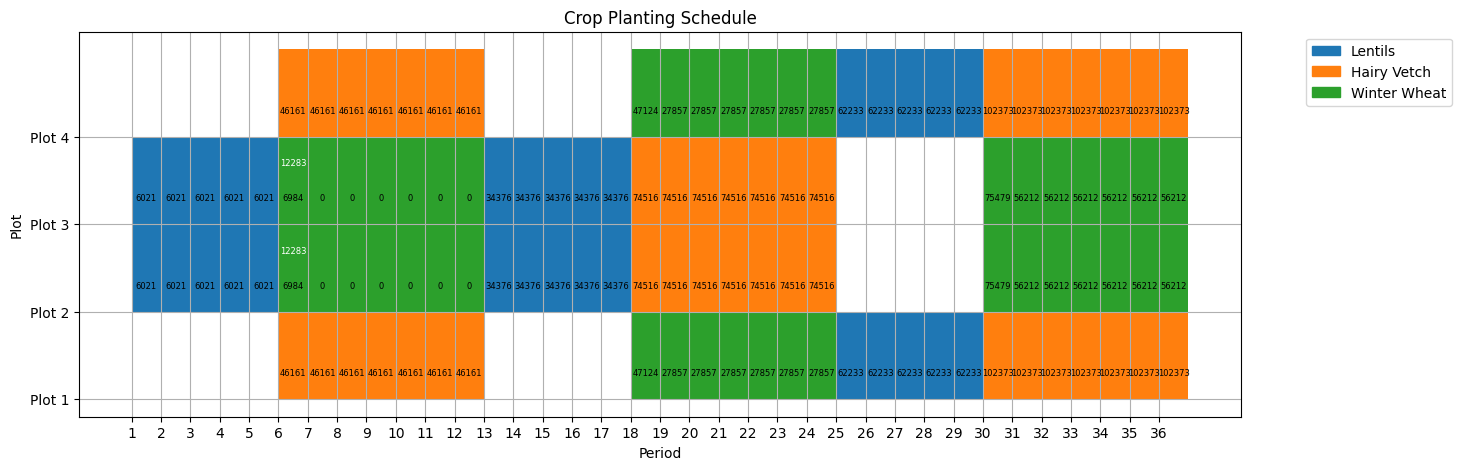

In [294]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np

storage_data = {}

for v in m.getVars():
    if v.varName.startswith("S[Nitrogen,"):
        # Extract the month and plot from the variable name
        parts = v.varName.strip('S[Nitrogen,').rstrip(']').split(',')
        month = int(parts[0])
        plot = int(parts[1])
        # Add storage values to the storage_data dictionary
        storage_data[(month, plot)] = round(v.x)

storage_data_N = {}

for v in m.getVars():
    if v.varName.startswith("Z[Nitrogen,"):
        # Extract the month and plot from the variable name
        parts = v.varName.split('[')[1].split(']')[0].split(',')
        nutrient = parts[0]  # This should be 'Nitrogen'
        month = int(parts[1])
        plot = int(parts[2])
        # Add nitrogen values to the storage_data_N dictionary
        storage_data_N[(month, plot)] = round(v.x)

model_output = []

# Iterate over all variables in the model
for v in m.getVars():
    if v.varName.startswith("x") and v.x > 0.5:
        # Append the variable name and its value as a tuple to the model_output list
        model_output.append((v.varName, v.x))

# Parse model output to extract planting information
planting_info = {}
for var_name, var_value in model_output:
    if var_value > 0.5 and var_name.startswith('x'):
        parts = var_name.lstrip('x[').rstrip(']').split(',')
        crop = parts[0]
        month = int(parts[1])
        plot = int(parts[2])
        planting_info.setdefault(crop, []).append((month, plot))

# Initialize plot matrix
plot_matrix = np.full((L, M), -1)

# Fill plot matrix with crop indices based on planting_info
crop_indices = {crop: idx for idx, crop in enumerate(planting_info)}
for crop, timings in planting_info.items():
    for month, plot in timings:
        plot_matrix[plot, month:month + duration[crop]] = crop_indices[crop]

# Create a colormap
cmap = mcolors.ListedColormap(['white'] + list(mcolors.TABLEAU_COLORS)[:len(crop_indices)])

# Generate the plot
fig, ax = plt.subplots(figsize=(15, 5))
for plot in range(L):
    for period in range(M):
        crop_index = plot_matrix[plot, period]
        if crop_index != -1:
            ax.broken_barh([(period, 1)], (plot, 1), facecolors=cmap(crop_index + 1))
            # Add storage text (lower half)
            if (period, plot) in storage_data:
                ax.text(period + 0.5, plot + 0.3, str(storage_data[(period, plot)]),
                        ha='center', va='center', fontsize=6, color='black')
            # Add nitrogen text (upper half), only if value is above 1
            if (period, plot) in storage_data_N and storage_data_N[(period, plot)] > 1:
                ax.text(period + 0.5, plot + 0.7, str(storage_data_N[(period, plot)]),
                        ha='center', va='center', fontsize=6, color='white')


# Customizing the plot
ax.set_yticks(range(L))
ax.set_yticklabels([f'Plot {i+1}' for i in range(L)])
ax.set_xticks(range(M))
ax.set_xticklabels(range(1, M + 1))
ax.set_xlabel('Period')
ax.set_ylabel('Plot')
ax.set_title('Crop Planting Schedule')
ax.grid(True)

# Adding a legend
legend_patches = [mpatches.Patch(color=cmap(idx + 1), label=crop) for crop, idx in crop_indices.items()]
ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

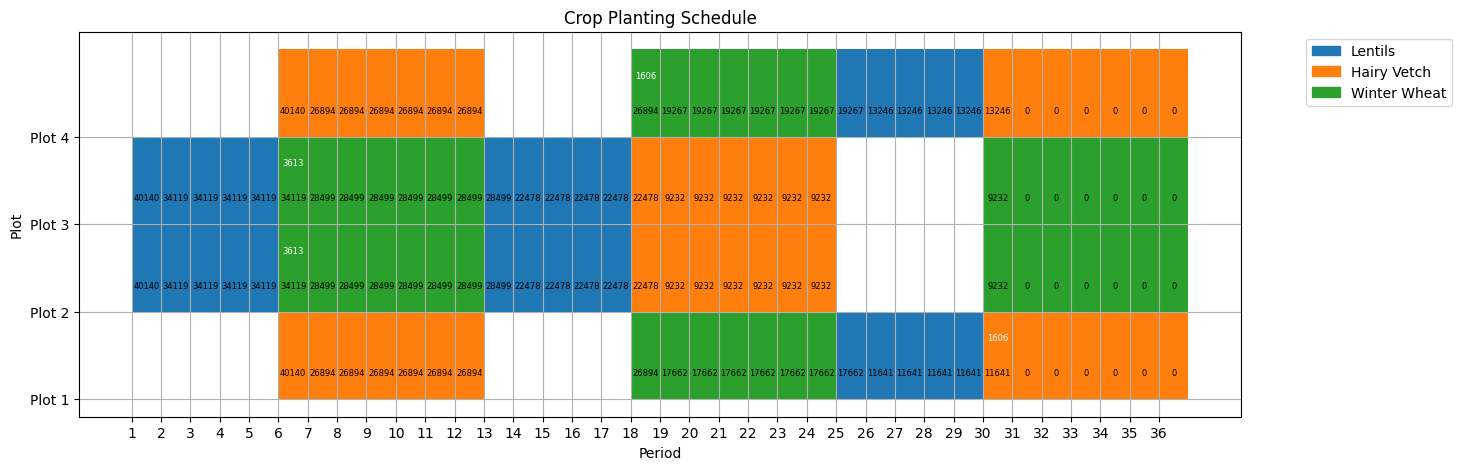

In [295]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np

storage_data = {}

for v in m.getVars():
    if v.varName.startswith("S[Phosphorus,"):
        # Extract the month and plot from the variable name
        parts = v.varName.strip('S[Phosphorus,').rstrip(']').split(',')
        month = int(parts[0])
        plot = int(parts[1])
        # Add storage values to the storage_data dictionary
        storage_data[(month, plot)] = round(v.x)

storage_data_Pho = {}

for v in m.getVars():
    if v.varName.startswith("Z[Phosphorus,"):
        # Extract the month and plot from the variable name
        parts = v.varName.split('[')[1].split(']')[0].split(',')
        nutrient = parts[0]  # This should be 'Nitrogen'
        month = int(parts[1])
        plot = int(parts[2])
        # Add nitrogen values to the storage_data_N dictionary
        storage_data_Pho[(month, plot)] = round(v.x)

model_output = []

# Iterate over all variables in the model
for v in m.getVars():
    if v.varName.startswith("x") and v.x > 0.5:
        # Append the variable name and its value as a tuple to the model_output list
        model_output.append((v.varName, v.x))

# Parse model output to extract planting information
planting_info = {}
for var_name, var_value in model_output:
    if var_value > 0.5 and var_name.startswith('x'):
        parts = var_name.lstrip('x[').rstrip(']').split(',')
        crop = parts[0]
        month = int(parts[1])
        plot = int(parts[2])
        planting_info.setdefault(crop, []).append((month, plot))

# Initialize plot matrix
plot_matrix = np.full((L, M), -1)

# Fill plot matrix with crop indices based on planting_info
crop_indices = {crop: idx for idx, crop in enumerate(planting_info)}
for crop, timings in planting_info.items():
    for month, plot in timings:
        plot_matrix[plot, month:month + duration[crop]] = crop_indices[crop]

# Create a colormap
cmap = mcolors.ListedColormap(['white'] + list(mcolors.TABLEAU_COLORS)[:len(crop_indices)])

# Generate the plot
fig, ax = plt.subplots(figsize=(15, 5))
for plot in range(L):
    for period in range(M):
        crop_index = plot_matrix[plot, period]
        if crop_index != -1:
            ax.broken_barh([(period, 1)], (plot, 1), facecolors=cmap(crop_index + 1))
            # Add storage text (lower half)
            if (period, plot) in storage_data:
                ax.text(period + 0.5, plot + 0.3, str(storage_data[(period, plot)]),
                        ha='center', va='center', fontsize=6, color='black')
            # Add nitrogen text (upper half), only if value is above 1
            if (period, plot) in storage_data_Pho and storage_data_Pho[(period, plot)] > 1:
                ax.text(period + 0.5, plot + 0.7, str(storage_data_Pho[(period, plot)]),
                        ha='center', va='center', fontsize=6, color='white')


# Customizing the plot
ax.set_yticks(range(L))
ax.set_yticklabels([f'Plot {i+1}' for i in range(L)])
ax.set_xticks(range(M))
ax.set_xticklabels(range(1, M + 1))
ax.set_xlabel('Period')
ax.set_ylabel('Plot')
ax.set_title('Crop Planting Schedule')
ax.grid(True)

# Adding a legend
legend_patches = [mpatches.Patch(color=cmap(idx + 1), label=crop) for crop, idx in crop_indices.items()]
ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

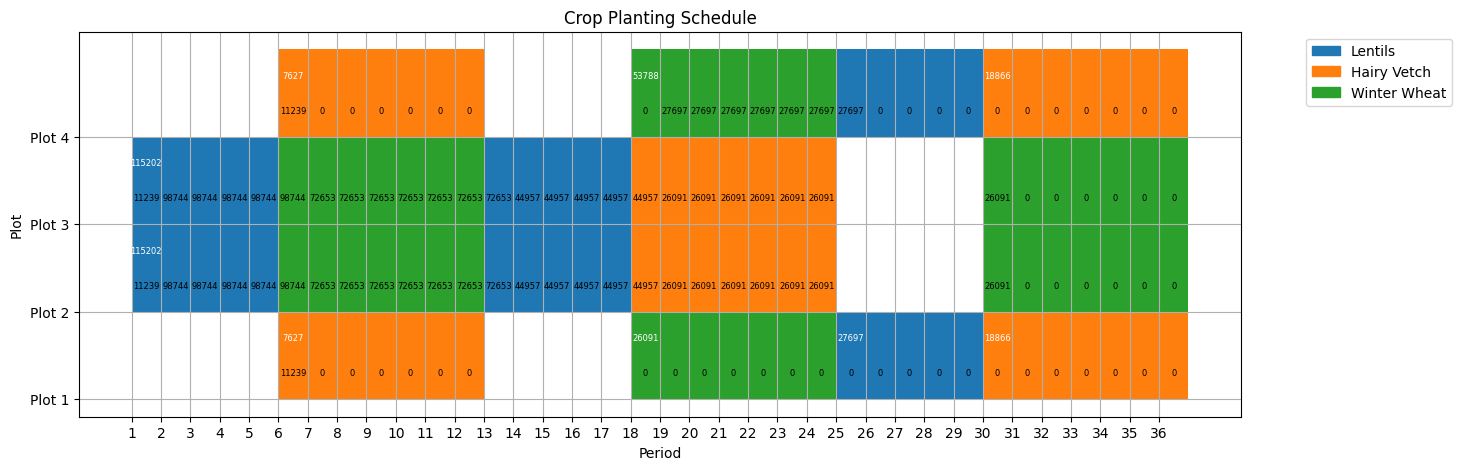

In [296]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np

storage_data = {}

for v in m.getVars():
    if v.varName.startswith("S[Potassium,"):
        # Extract the month and plot from the variable name
        parts = v.varName.strip('S[Potassium,').rstrip(']').split(',')
        month = int(parts[0])
        plot = int(parts[1])
        # Add storage values to the storage_data dictionary
        storage_data[(month, plot)] = round(v.x)

storage_data_Po = {}

for v in m.getVars():
    if v.varName.startswith("Z[Potassium,"):
        # Extract the month and plot from the variable name
        parts = v.varName.split('[')[1].split(']')[0].split(',')
        nutrient = parts[0]  # This should be 'Nitrogen'
        month = int(parts[1])
        plot = int(parts[2])
        # Add nitrogen values to the storage_data_N dictionary
        storage_data_Po[(month, plot)] = round(v.x)

model_output = []

# Iterate over all variables in the model
for v in m.getVars():
    if v.varName.startswith("x") and v.x > 0.5:
        # Append the variable name and its value as a tuple to the model_output list
        model_output.append((v.varName, v.x))

# Parse model output to extract planting information
planting_info = {}
for var_name, var_value in model_output:
    if var_value > 0.5 and var_name.startswith('x'):
        parts = var_name.lstrip('x[').rstrip(']').split(',')
        crop = parts[0]
        month = int(parts[1])
        plot = int(parts[2])
        planting_info.setdefault(crop, []).append((month, plot))

# Initialize plot matrix
plot_matrix = np.full((L, M), -1)

# Fill plot matrix with crop indices based on planting_info
crop_indices = {crop: idx for idx, crop in enumerate(planting_info)}
for crop, timings in planting_info.items():
    for month, plot in timings:
        plot_matrix[plot, month:month + duration[crop]] = crop_indices[crop]

# Create a colormap
cmap = mcolors.ListedColormap(['white'] + list(mcolors.TABLEAU_COLORS)[:len(crop_indices)])

# Generate the plot
fig, ax = plt.subplots(figsize=(15, 5))
for plot in range(L):
    for period in range(M):
        crop_index = plot_matrix[plot, period]
        if crop_index != -1:
            ax.broken_barh([(period, 1)], (plot, 1), facecolors=cmap(crop_index + 1))
            # Add storage text (lower half)
            if (period, plot) in storage_data:
                ax.text(period + 0.5, plot + 0.3, str(storage_data[(period, plot)]),
                        ha='center', va='center', fontsize=6, color='black')
            # Add nitrogen text (upper half), only if value is above 1
            if (period, plot) in storage_data_Po and storage_data_Po[(period, plot)] > 1:
                ax.text(period + 0.5, plot + 0.7, str(storage_data_Po[(period, plot)]),
                        ha='center', va='center', fontsize=6, color='white')


# Customizing the plot
ax.set_yticks(range(L))
ax.set_yticklabels([f'Plot {i+1}' for i in range(L)])
ax.set_xticks(range(M))
ax.set_xticklabels(range(1, M + 1))
ax.set_xlabel('Period')
ax.set_ylabel('Plot')
ax.set_title('Crop Planting Schedule')
ax.grid(True)

# Adding a legend
legend_patches = [mpatches.Patch(color=cmap(idx + 1), label=crop) for crop, idx in crop_indices.items()]
ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()